# Code for the Gearbox fault detection model, part of the portfolio at https://zohaibdr.github.io/

In [57]:
import numpy as np    # use of TPOT requires numpy version 1.23 or below 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, signal, stats
# %pip install tqdm 
from tqdm.notebook import tqdm
%matplotlib inline 

# About the data
National Renewable Energy Laboratory. (2018). Gearbox Fault Diagnosis Data [data set]. Retrieved from https://data.openei.org/submissions/623.

The [dataset description](https://data.openei.org/submissions/623) includes the following details:

**Gearbox Fault Diagnosis Data set** include the vibration dataset recorded by using SpectraQuest’s Gearbox Fault Diagnostics Simulator.
Dataset has been recorded using 4 vibration sensors placed in four different direction, and under variation of load from '0' to '90' percent. Two different scenario are included:
1) Healthy condition and
2) Broken Tooth Condition 
3) There are 20 files in total, 10 for healthy gearbox and 10 from broken one. 
4) Each file corresponds to a given load from 0% to 90% in steps of 10%.


The filename structure is indicative of the contents of the file:
* First character being "h" for the healthy gearbox, "b" for the gearbox with the broken tooth
* Last 1-2 characters being the gearbox load (0-90) during the measurement

Between those pieces of information, each filename has the characters "30hz".

We can interpret this to mean that the vibration data was collected at a data rate of 30Hz. This gives us information on the duration of the data collection in each file (i.e. number of samples / 30 = time in seconds), and also allows us to interpret the data as a continuous signal and analyze the data in the frequency domain as well as the time domain.

In [58]:
import os

# Display file list in the data folder 
for dirname, _, filenames in os.walk('data'):

    for filename in filenames:
        print(os.path.join(dirname, filename))

data\b30hz0.csv
data\b30hz10.csv
data\b30hz20.csv
data\b30hz30.csv
data\b30hz40.csv
data\b30hz50.csv
data\b30hz60.csv
data\b30hz70.csv
data\b30hz80.csv
data\b30hz90.csv
data\h30hz0.csv
data\h30hz10.csv
data\h30hz20.csv
data\h30hz30.csv
data\h30hz40.csv
data\h30hz50.csv
data\h30hz60.csv
data\h30hz70.csv
data\h30hz80.csv
data\h30hz90.csv


In [59]:
dfs = []
# print(filenames)
# print(dirname)

for dirname, _, filenames in tqdm(os.walk('data')):
    for filename in tqdm(filenames, leave=False):
        
        # the gearbox state is in the filename prefix (h = healthy, b = broken tooth)
        state = filename[0]
        
        # the load is in the filename suffix
        load = int(filename.split('.')[0][5:])
        
        # read in the file
        df = pd.read_csv(os.path.join(dirname, filename))
        
        # include the healthy/broken state
        df['state'] = state
        
        # include the load
        df['load'] = load
        
        # append to a list
        dfs.append(df)

# concatenate all the datasets and reset the index
df = pd.concat(dfs).reset_index().rename(columns={'index':'sample_index'})
df

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

sample_index         a1        a2        a3         a4 state  load
0                   0   2.350390  1.454870 -1.667080  -2.055610     b     0
1                   1   2.452970  1.400100 -2.825100   0.984487     b     0
2                   2  -0.241284 -0.267390  0.793540   0.605862     b     0
3                   3   1.130270 -0.890918  0.696969   0.613068     b     0
4                   4  -1.296140  0.980479 -1.130560  -0.346971     b     0
...               ...        ...       ...       ...        ...   ...   ...
2021114        106747   0.677448 -3.234410 -1.725990  -3.143020     h    90
2021115        106748 -10.575400  7.725400 -2.184010   2.569650     h    90
2021116        106749  -4.033290  2.576920  1.468430   2.728910     h    90
2021117        106750   1.868670 -5.089400  5.342290  -1.365630     h    90
2021118        106751   7.581480  6.205960 -6.121330  11.548300     h    90

[2021119 rows x 7 columns]

In [60]:
df.sample(10) 

sample_index         a1         a2        a3        a4 state  load
734613          46229   1.563930  -6.610310  0.068906  -1.03419     b    70
1493887         92032   1.903270   3.897330  2.503050   6.01630     h    40
780309          91925   1.029710   0.923660  0.856687 -12.42510     b    70
216212          16276  -4.294300  -0.553411 -1.144690   8.19888     b    20
420182          15958  -0.837149   0.123458 -1.934350   3.45617     b    40
1186369         92226 -17.234200 -14.232100  1.930170  -8.57914     h    10
316939           2571   3.098550  -0.747421  2.090680  -1.17225     b    30
1987604         73237  -1.916410  -4.421210  1.401870   5.56066     h    90
1788800         75649 -12.082700  -8.664450  1.299350  -2.28929     h    70
743850          55466  -2.754790  -2.445520 -1.492150   5.28529     b    70

To analyze this dataset, I combined the reading from all four sensors into a single column using `melt` function, tagged with the `sensor`, `load` and `state` of the gearbox. 

In [61]:
df_melt = df.melt(
    id_vars=['sample_index', 'state', 'load'],
    value_vars=['a1','a2','a3','a4'],
    var_name='sensor',
    value_name='reading'
)
df_melt 

sample_index state  load sensor    reading
0                   0     b     0     a1   2.350390
1                   1     b     0     a1   2.452970
2                   2     b     0     a1  -0.241284
3                   3     b     0     a1   1.130270
4                   4     b     0     a1  -1.296140
...               ...   ...   ...    ...        ...
8084471        106747     h    90     a4  -3.143020
8084472        106748     h    90     a4   2.569650
8084473        106749     h    90     a4   2.728910
8084474        106750     h    90     a4  -1.365630
8084475        106751     h    90     a4  11.548300

[8084476 rows x 5 columns]

# EDA


How many samples are there in each file?

<AxesSubplot: xlabel='count', ylabel='load'>

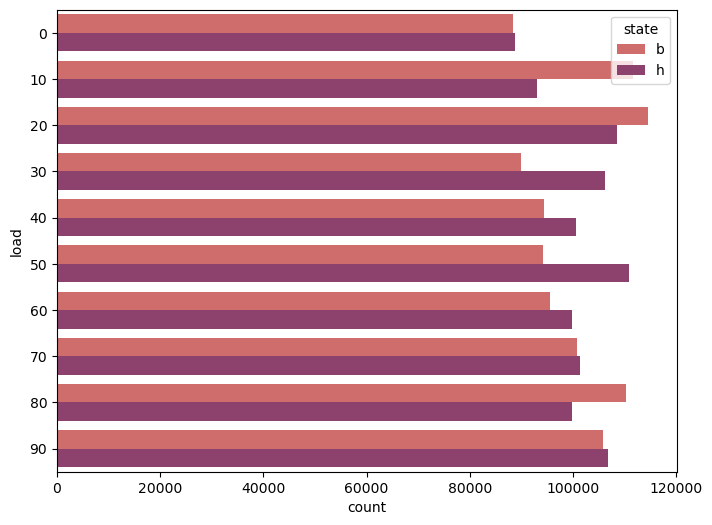

In [62]:
plt.figure(figsize=(8,6))
sns.countplot(
    data=df_melt[df_melt.sensor=='a3'],
    y='load',
    hue='state',
    palette='flare'
)


What's the minimum and maximum number of data points and what does this mean in terms of time?

In [63]:
# Which set has the lowest number of samples
lowest_samples = df.groupby(['state','load']).sample_index.count().min()
biggest_samples = df.groupby(['state','load']).sample_index.count().max()

print(f'Lowest number of samples = {lowest_samples}')
print(f'Translates to {lowest_samples/30:0.2f} seconds or {lowest_samples/30/60:0.2f} minutes') 

print(f'Lowest number of samples = {biggest_samples}')
print(f'Translates to {biggest_samples/30:0.2f} seconds or {biggest_samples/30/60:0.2f} minutes') 


Lowest number of samples = 88320
Translates to 2944.00 seconds or 49.07 minutes
Lowest number of samples = 114432
Translates to 3814.40 seconds or 63.57 minutes


In [64]:
# helper function to filter the dataset
def rdg(df, state=None, load=None, sensor=None):
    # if state is specified, return only that state, else return both 
    df_st = df[df.state==state] if state is not None else df  
    # taken previous df, see if load is speficified, return only that load, else return all loads data 
    df_lo = df_st[df_st.load==load] if load is not None else df_st
    # likewise for sensor 
    df_se = df_lo[df_lo.sensor==sensor] if sensor is not None else df_lo
    
    return df_se  #return final df for specified state, load and sensor 


# Time domain analysis
What does the data from one sensor look like?

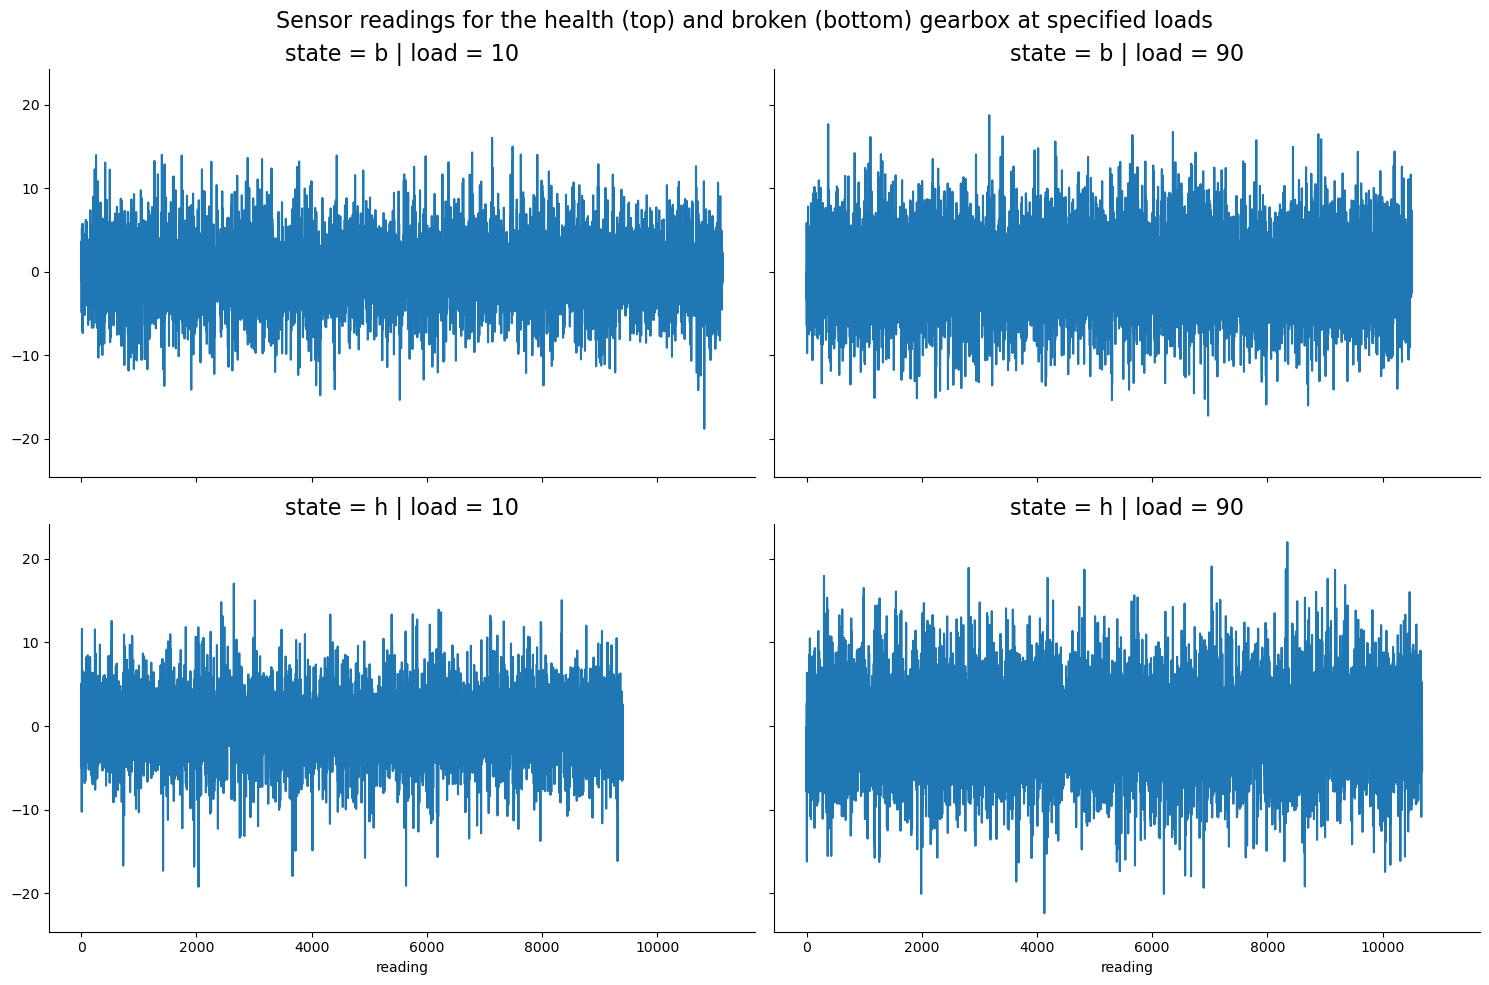

In [65]:
# take a random somple of the dataset for easier visualization 
df_melt_sample = df_melt.sample(frac=0.1) 

sensor1 = 'a3'
load1 = 10
load2 = 90

g = sns.FacetGrid(
    data=pd.concat([
        rdg(df_melt_sample, load=load1, sensor=sensor1),
        rdg(df_melt_sample, load=load2, sensor=sensor1)
    ]),
    col='load',
    row='state',
    height=5,
    aspect=1.5
)
g.fig.suptitle('Sensor readings for the health (top) and broken (bottom) gearbox at specified loads', fontsize=16)
g.set_titles(size=16)

g.map(plt.plot, 'reading')
plt.show() 


For a more comprehensive visual analysis, I used seaborn 'violin' and 'boxenplot' plots to show the distribution of the `reading`s and compare like for like between the healthy and broken gearboxes for the same `load` and `sensor`.

We can now use the seaborn [`catplot` function](https://seaborn.pydata.org/generated/seaborn.catplot.html) to break down the data by `load`, `sensor` and `state`, and plot the distribution of `reading` within each group.

In [66]:
print('Each column is a different sensor, each row is increasing load')
print('Each plot shows the distribution of reading values between the healthy and broken gearbox')

# df_melt['dummy'] = 1

# h= sns.catplot(
#     data=df_melt,
#     row='load', col='sensor',
#     x='dummy', #'state', 
#     y='reading',
#     hue = 'state',
#     kind='boxen',   #boxen is an enhanced box plot for larger datasets
#     height=5 
# )

# h.fig.suptitle('Distribution of sensor readings from both gearboxes at different loads', fontsize=18)
# h.set_titles(size=25)


Each column is a different sensor, each row is increasing load
Each plot shows the distribution of reading values between the healthy and broken gearbox


In [67]:
# Split violin plot
df_melt2 = df_melt.sample(1000)

# i= sns.catplot(
#     data=df_melt,
#     row='load', col='sensor',
#     x='dummy', 
#     y='reading',
#     hue= 'state',
#     kind='violin',
#     split=True,   #applicable to violin plots 
#     legend_out=False,
#     sharex=True, sharey=True, 
#     height=5 
# )

# i.set_titles(size=25)


### Observing the standard deviation of sensors against state 

In [68]:

# display(df_melt.groupby(['sensor','state']).reading.mean().unstack())
StdTable = df_melt.groupby(['sensor','state']).reading.std().unstack()

StdTable.columns = ['broken', 'healthy']
StdTable.style.set_caption("Hello World")

display(StdTable.style.format(precision=2).set_caption("Standard Deviation"))
# styling source https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html


## Feature Engineering 

In [69]:
data = []
classes = [] 

test = df_melt.groupby(['state','load','sensor']).count()
# there are 80 unique combinations of state, load and sensor. Under each, there are 88k to 114k values 

for (state,load,sensor),g in df_melt.groupby(['state','load','sensor']):
    #the loop will run 80 times, once for each unique combination  
    # take one combination at a time and save in 'vals'
    vals = g.reading.values 
    #split 'vals' into subarrays of specified size 
    splits = np.split(vals, range(500, vals.shape[0],500))
    # 200+ splits if the combination has 100k values and size is 500

    for s in splits[:-1]:  # except the last one 
        data.append(  # append all splits vertically (rows= 80 by no of splits in each combination )
            {  # a dictionary 
            'sens_a1': int(sensor=='a1'),
            'sens_a2': int(sensor=='a2'),
            'sens_a3': int(sensor=='a3'),
                    # no need to put a4: if a1-a3 are 0, then it's sensor a4
            
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
        }
        )
        classes.append(int(state=='b'))  # positive class indicates fault



In [70]:
df_data = pd.DataFrame(data)
print(df_data) 

data = df_data.values
classes = np.array(classes)

print(f'Fault class: {np.sum(classes)} ({np.sum(classes)/len(classes):0.1%})') 


       sens_a1  sens_a2  sens_a3  load      mean       std      kurt      skew
0            1        0        0     0 -0.009800  2.764030  0.293424 -0.246560
1            1        0        0     0  0.055134  4.367687  0.845903  0.052560
2            1        0        0     0  0.004517  3.365995  0.117913 -0.163872
3            1        0        0     0 -0.025904  3.653444  0.854682 -0.063745
4            1        0        0     0  0.016573  3.290128  0.527112 -0.140687
...        ...      ...      ...   ...       ...       ...       ...       ...
16115        0        0        0    90 -0.217168  4.901528  0.172630 -0.064055
16116        0        0        0    90 -0.208095  5.459520  0.548103 -0.067735
16117        0        0        0    90  0.327846  5.843711  0.616975  0.040888
16118        0        0        0    90  0.172448  5.003728  1.207897  0.022715
16119        0        0        0    90  0.225026  5.806593  0.536033 -0.233706

[16120 rows x 8 columns]
Fault class: 8016 (49.7%)


In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, classes,
    train_size=0.7,
    random_state=42,
    stratify=classes
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}') 


Training data: (11284, 8)
Test data: (4836, 8)


In [74]:
# !pip install tpot

from tpot import TPOTClassifier   # REQUIRES NUMPY 1.23 OR LOWER 
# https://epistasislab.github.io/tpot/using/

# %%time
tpot_td = TPOTClassifier(generations=5, random_state=42, max_time_mins=20, verbosity=2, cv=3)
tpot_td.fit(X_train, y_train)

print(f'Best accuracy score: {tpot_td.score(X_test, y_test):0.2%}')
tpot.export('tpot_gears_pipeline.py')


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7939554046272584

Generation 2 - Current best internal CV score: 0.7939554046272584

Generation 3 - Current best internal CV score: 0.7948415523808406

20.04 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=2, min_samples_split=8, n_estimators=100)
Best accuracy score: 79.98%


NameError: name 'tpot' is not defined

In [75]:
pd.Series([
    model.split('(')[0]
    for model
    in tpot_td.evaluated_individuals_.keys()
]).value_counts()


ExtraTreesClassifier          106
RandomForestClassifier         52
DecisionTreeClassifier         52
KNeighborsClassifier           50
XGBClassifier                  47
GradientBoostingClassifier     26
MLPClassifier                  24
BernoulliNB                    20
GaussianNB                     18
SGDClassifier                  12
LinearSVC                      12
LogisticRegression              7
MultinomialNB                   1
dtype: int64

Overall accuracy', 0.800
Precision: 0.796
Recall: 0.803
F1: 0.800
_____Confustion matrix__________ 

 [[1936  495]
 [ 473 1932]]
_____Classification report________ 

               precision    recall  f1-score   support

           0       0.80      0.80      0.80      2431
           1       0.80      0.80      0.80      2405

    accuracy                           0.80      4836
   macro avg       0.80      0.80      0.80      4836
weighted avg       0.80      0.80      0.80      4836



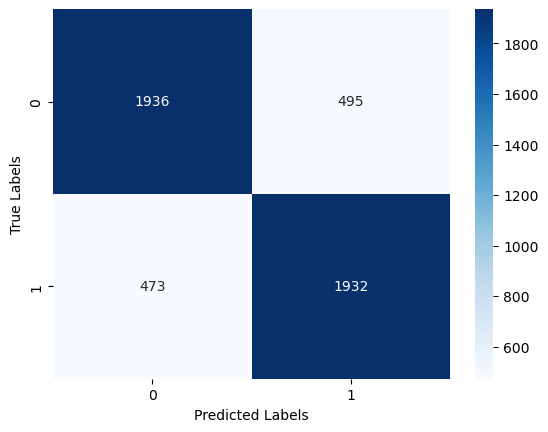

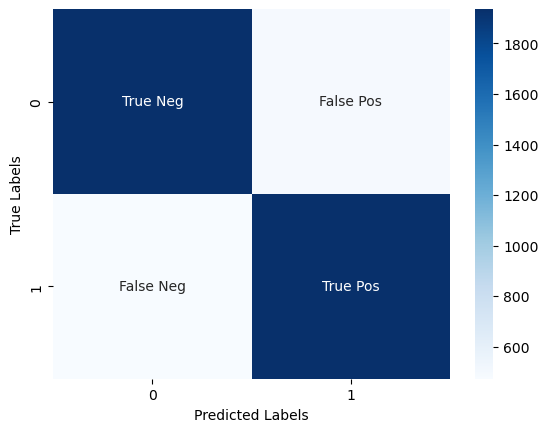

In [97]:
# Model evaluation 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

def evaluate_classifier(classifier, y_test, X_test):   #just give it the classifier and the true 'y' values 
    """
    *** Calculates accuracy scores and prints the resutls. Does not return anything *** 
    """
    y_predict = classifier.predict(X_test)
    print("Overall accuracy', %.3f" %accuracy_score(y_test, y_predict))
    # calculate prediction
    precision = precision_score(y_test, y_predict)

    print('Precision: %.3f' % precision)
    recall = recall_score(y_test, y_predict)
    print('Recall: %.3f' % recall)
    f1 = f1_score(y_test, y_predict)
    print('F1: %.3f' % f1)

    print('_____Confustion matrix__________ \n\n', confusion_matrix(y_test, y_predict))
    print('_____Classification report________ \n\n', classification_report(y_test, y_predict))
    s= sns.heatmap(confusion_matrix(y_test, y_predict), annot=True, fmt='1', cmap='Blues')
    s.set( xlabel='Predicted Labels', ylabel='True Labels')
    

    # to plot just the labels
    plt.figure()
    labels = ['True Neg','False Pos','False Neg','True Pos']
    labels = np.asarray(labels).reshape(2,2)
    s2 = sns.heatmap(confusion_matrix(y_test, y_predict), annot=labels, fmt='', cmap='Blues')
    s2.set( xlabel='Predicted Labels', ylabel='True Labels')

    #Make classfication report pretty 
    

#Now call this function 
evaluate_classifier(tpot_td, y_test, X_test)



# Frequency domain analysis
Looking at the vibration data across time is useful, but vibrations are occurring at different frequencies - this is very difficult to identify from the time-based analysis. A frequency analysis of the data may yield some more tangible features.

A frequency analysis uses Fourier transforms to convert signal data (e.g. vibration readings) into its component frequencies. Let's start with a single sensor reading.

In [ ]:
sensor_data = rdg(df_melt, 'h', 10, 'a4').reading.values

46465 total number of frequency points


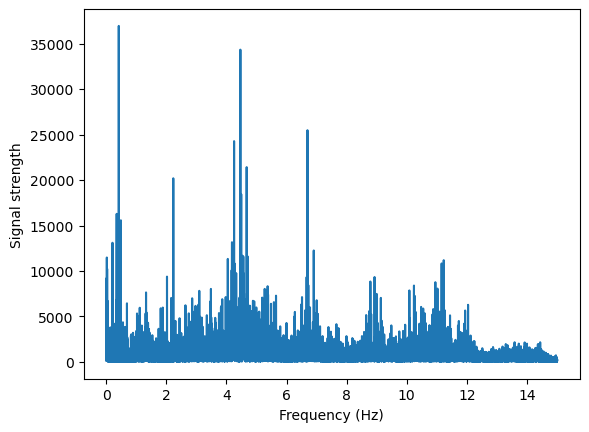

In [ ]:
y = np.abs(fft.rfft(sensor_data))
x = fft.rfftfreq(sensor_data.shape[0], 1/30)  # 30Hz data rate
print(f"{y.shape[0]} total number of frequency points")

plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Signal strength')
plt.show()

We see some peaks - let's see if we can identify those peaks:

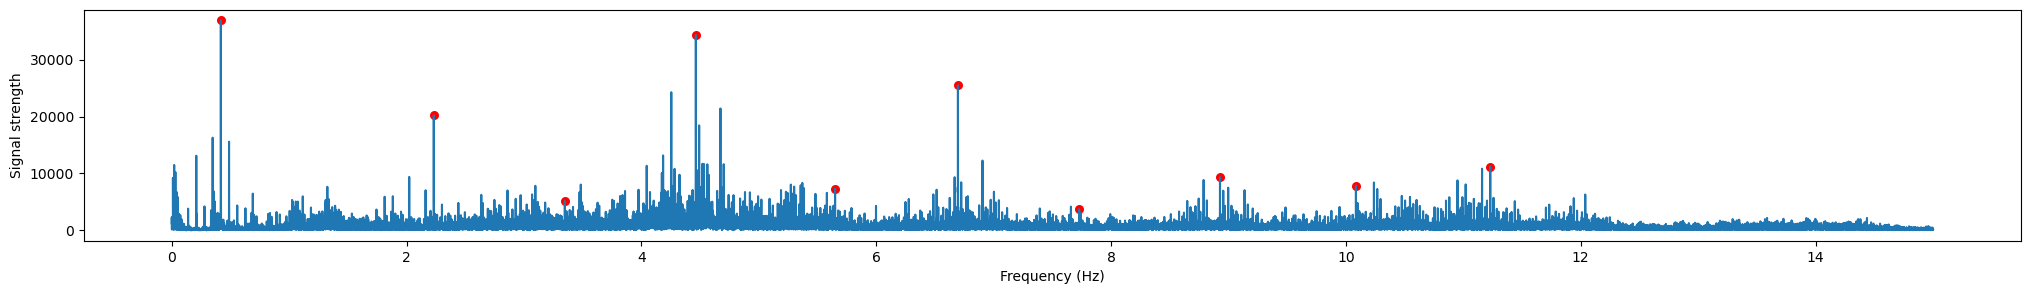

In [ ]:
y = np.abs(fft.rfft(sensor_data))
x = fft.rfftfreq(sensor_data.shape[0], 1/30)  # 30Hz data rate

fig, ax = plt.subplots(figsize=(25,3))
ax.plot(x, y)

# find peaks that are
#   at least 1Hz apart (number of frequency points / max frequency)
x_peak_spacing = y.shape[0] / x.max()
#   rising above surrounding values by the 99th percentile of the values
x_peak_prominence = np.quantile(y,0.99)

peaks, _ = signal.find_peaks(y, distance=x_peak_spacing, prominence=x_peak_prominence)

for peak in peaks:
    ax.scatter(x=x[peak], y=y[peak], c='r', marker='o', s=30)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Signal strength')
plt.show()

In [ ]:
[x[peak] for peak in peaks]

[0.41838842975206614,
 2.2317277892561984,
 3.347753099173554,
 4.463455578512397,
 5.64921229338843,
 6.695506198347108,
 7.72759555785124,
 8.927233987603307,
 10.08490444214876,
 11.228693181818182]

We see primary harmonics at 2.23Hz intervals (2.23, 4.46, 6.70, etc.) and minor peaks at intervals between those (3.35, 5.65, 7.73, etc).

Another view is the Power Spectral Density:

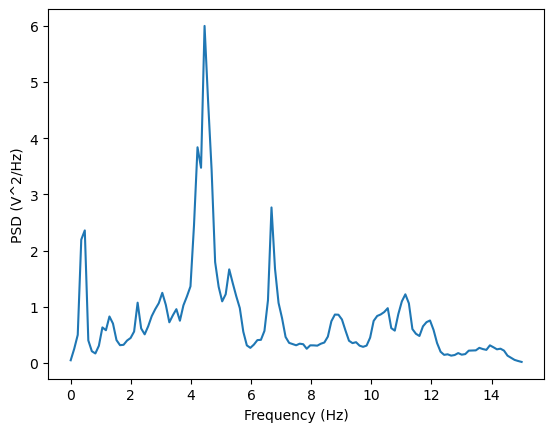

In [ ]:
x, y = signal.welch(sensor_data, fs=30) # 30Hz data rate
plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.show()

This is easier to see.

Let's plot the PSD for each sensor, at each load and compare the healthy and broken gearbox signals. We can also correlate the power values for each frequency between the healthy and broken gearboxes to see how well they line up.

The correlation between the two spetra is shown in the title of each plot

  0%|          | 0/40 [00:00<?, ?it/s]

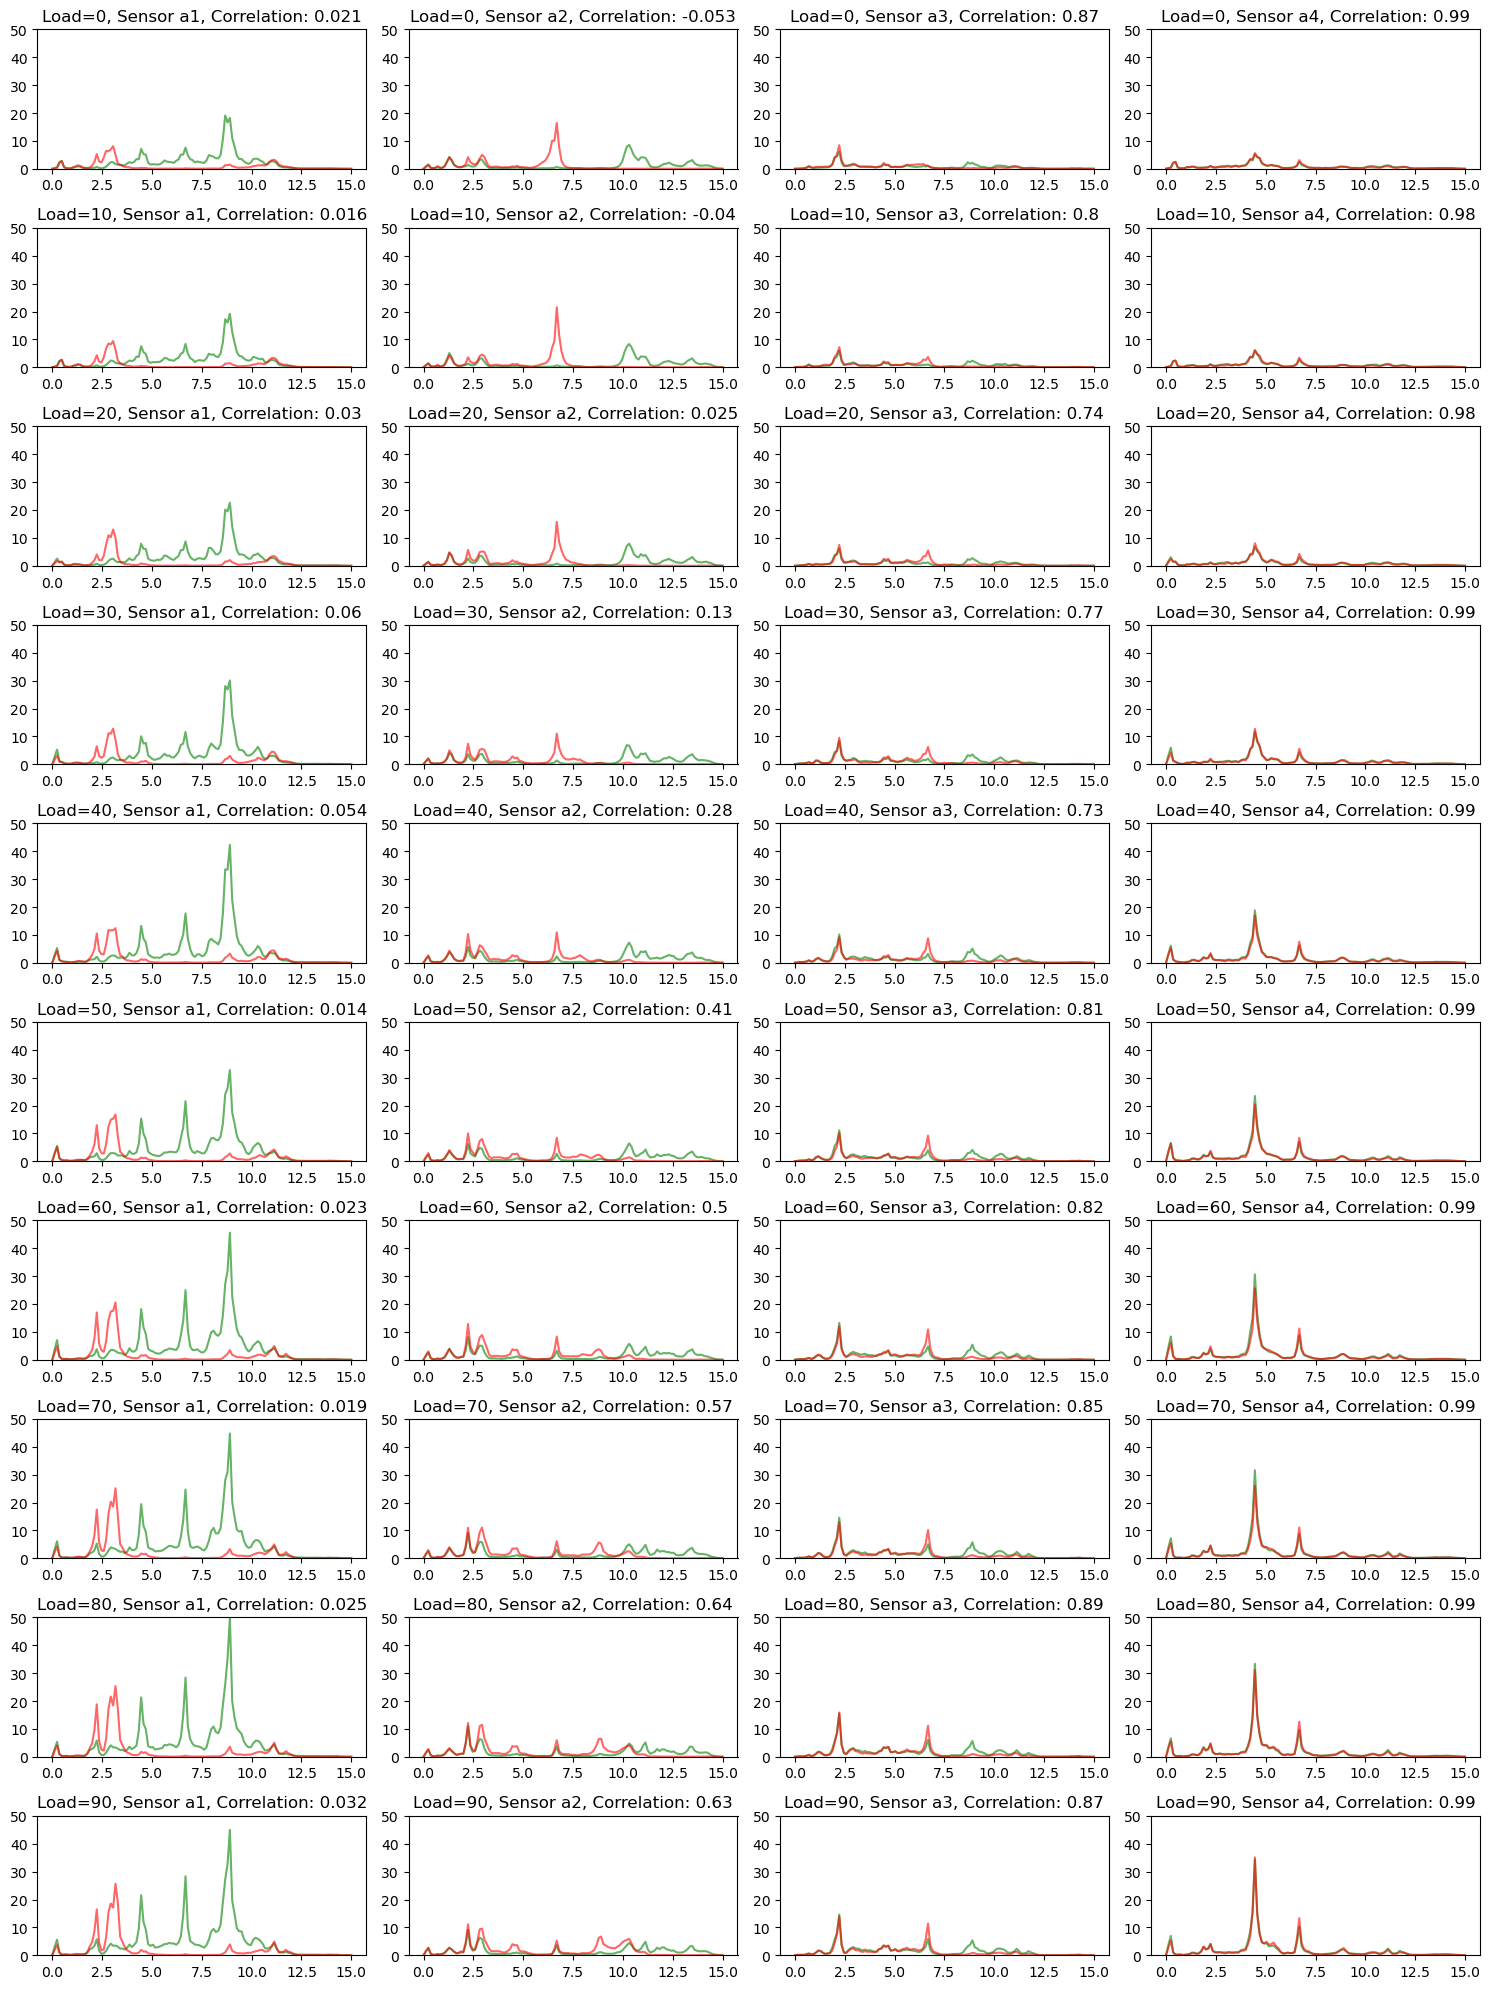

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=10, figsize=(15,20))
for ((load,sensor), dfg), axi in tqdm(zip(df_melt.groupby(['load','sensor']), ax.ravel()), total=40):
    healthy_raw = dfg[dfg.state=='h'].reading.values
    broken_raw = dfg[dfg.state=='b'].reading.values
    
    fh, Ph = signal.welch(healthy_raw, fs=30)
    fb, Pb = signal.welch(broken_raw, fs=30)

    axi.plot(fh, Ph, c='g', alpha=0.6)
    axi.plot(fb, Pb, c='r', alpha=0.6)
    axi.set_ylim(0,50)
    axi.set_title(f'Load={load}, Sensor {sensor}, Correlation: {np.corrcoef(Ph, Pb)[0,1]:0.2}')
plt.tight_layout()
plt.show()

Here it's clear that while there's hardly any difference in the PSD on sensor `a4`, the PSD for the other sensors show marked differences. For sensors `a1`, `a2` and `a3` the signal power at the higher frequencies is much lower in the readings from the gearbox with the broken tooth. This pattern is visible across all loads.

There is also a marked peak on sensor `a2` readings at the 6.7Hz harmonic, which is more prominent at lower loads.

Let's see if the pattern changes over time. We can do this with a spectrograph view.

  0%|          | 0/80 [00:00<?, ?it/s]

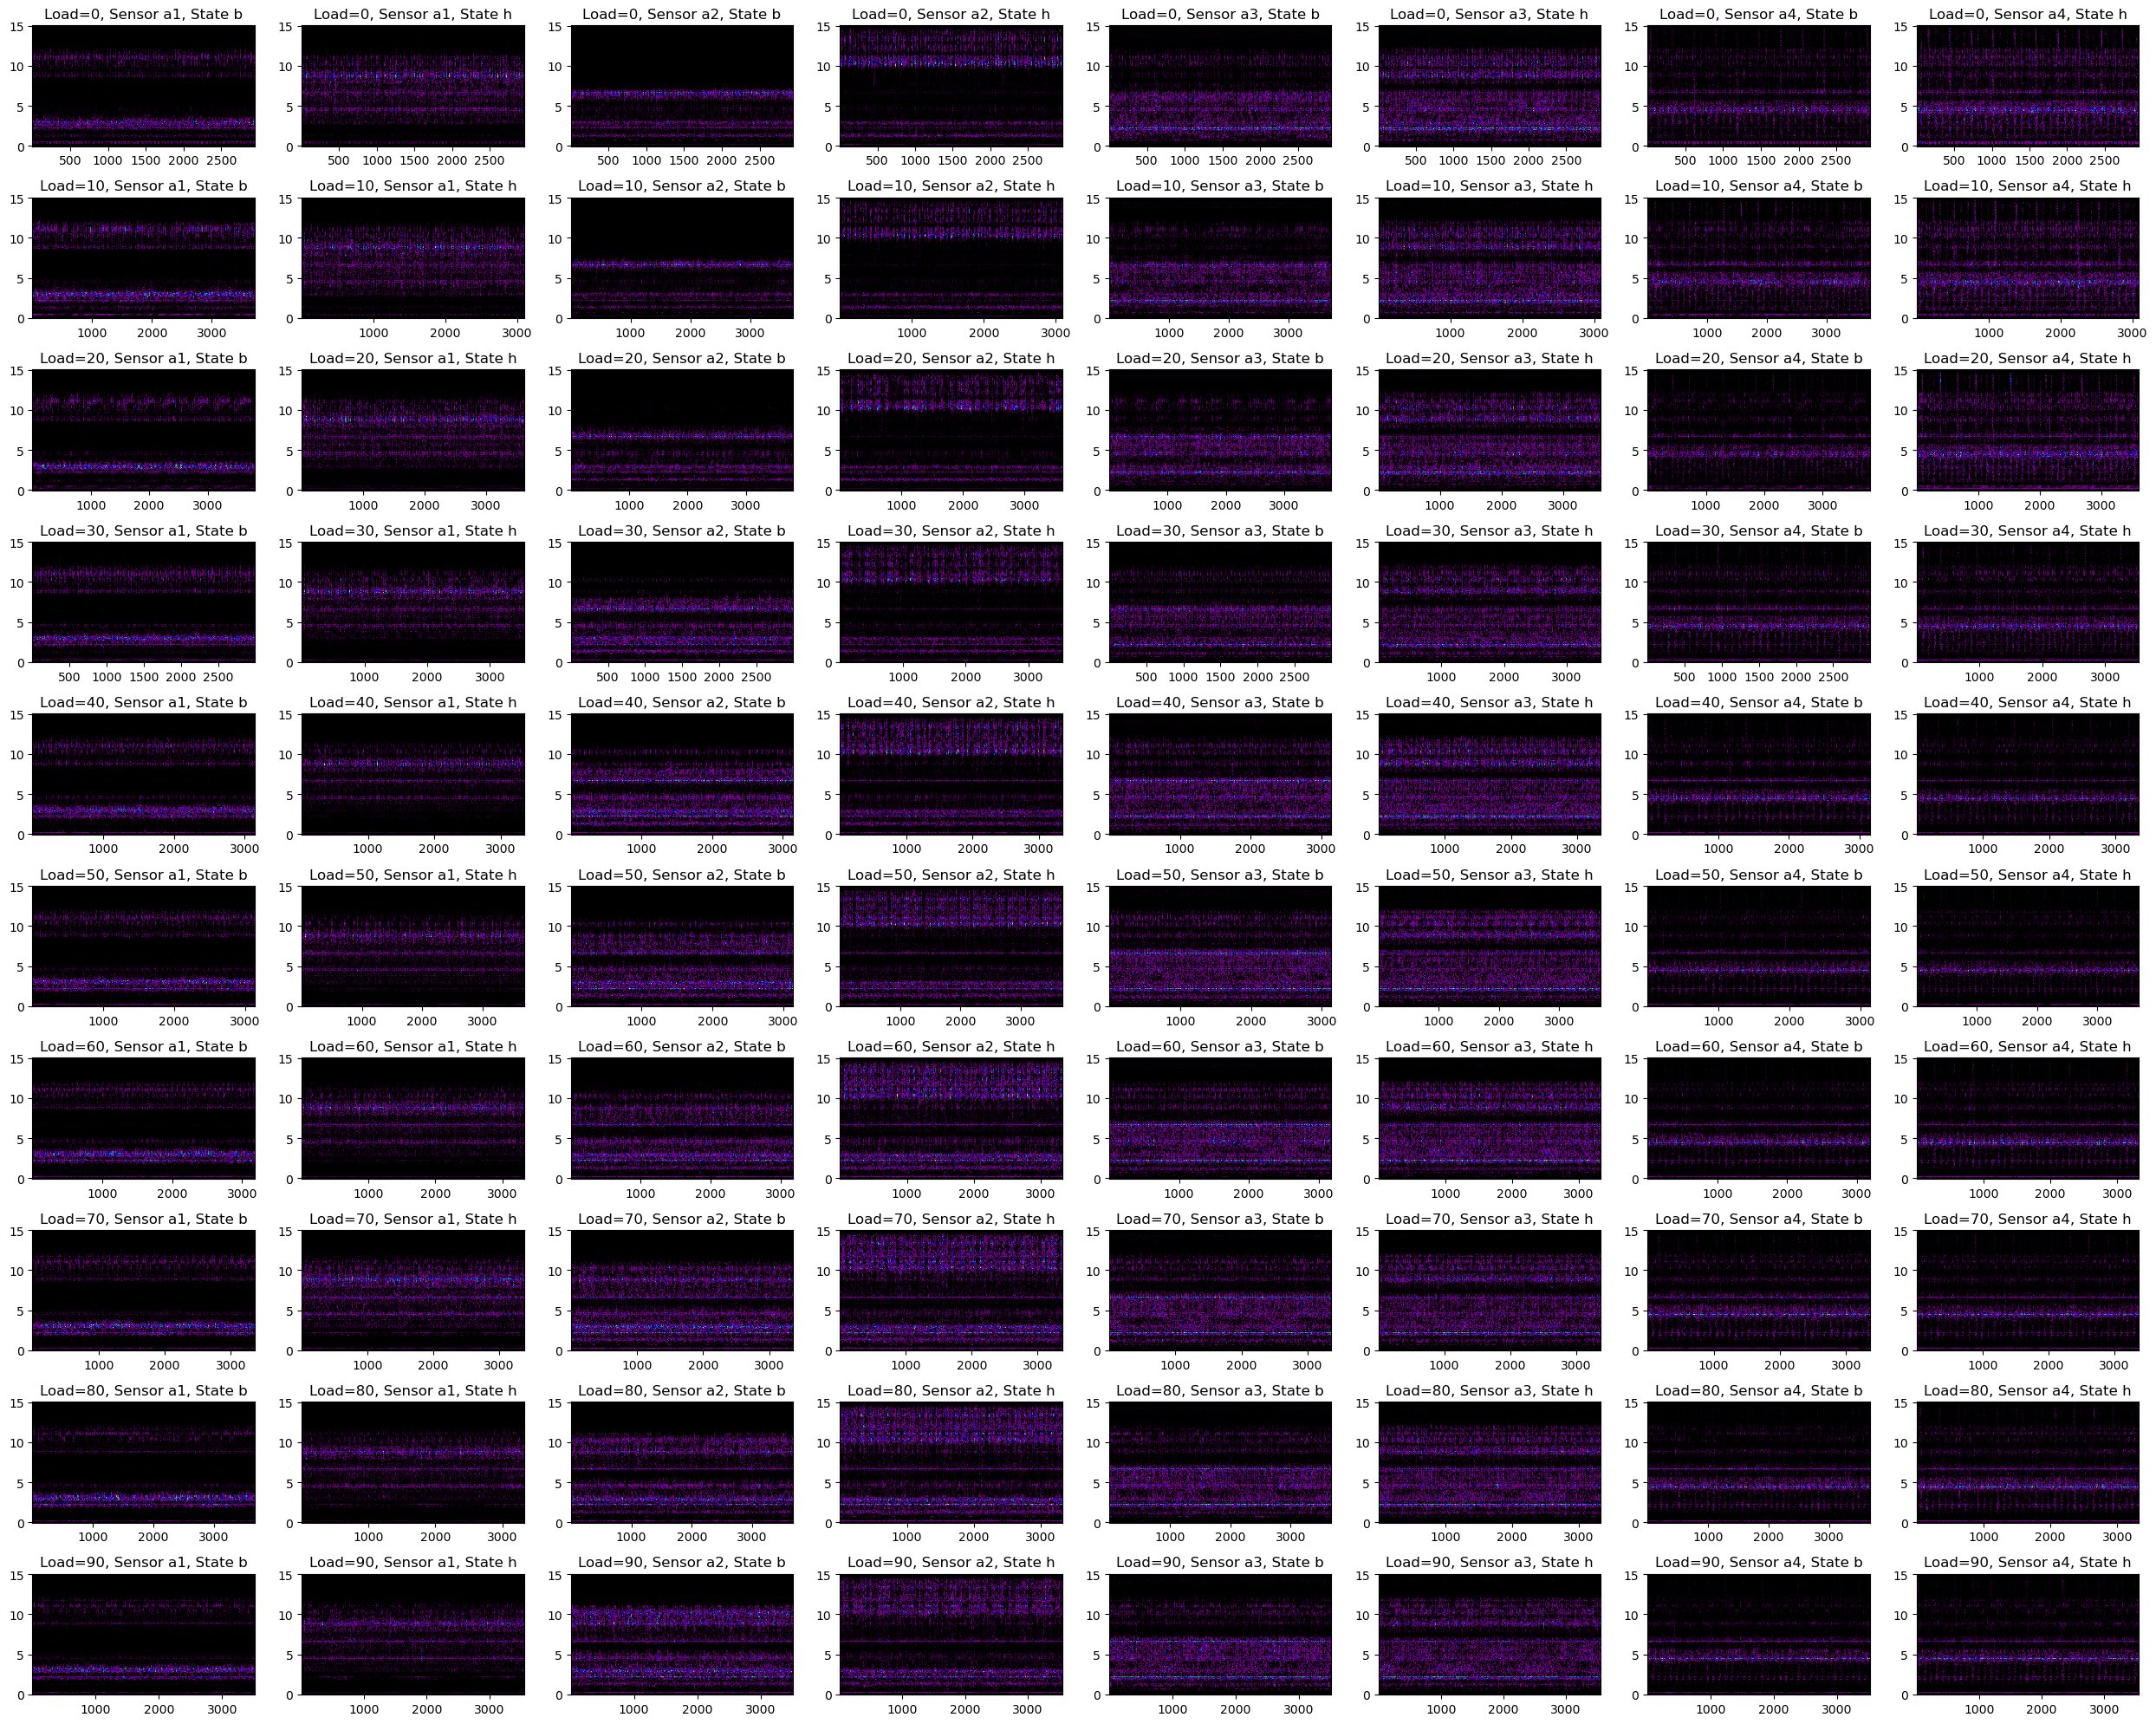

In [ ]:
fig, ax = plt.subplots(ncols=8, nrows=10, figsize=(25,20))
for ((load, sensor, state), dfg), axi in tqdm(zip(df_melt.groupby(['load','sensor','state']), ax.ravel()), total=80):
    raw = dfg.reading.values
    f, t, Sxx = signal.spectrogram(raw, fs=30)  # 30Hz data rate
    axi.pcolormesh(t, f, Sxx, cmap='nipy_spectral')
    axi.set_title(f'Load={load}, Sensor {sensor}, State {state}')
plt.tight_layout()
plt.show()

The spectrum does not change over time.

In [ ]:
data = []
labels = []
for (state,load,sensor),g in df_melt.groupby(['state','load','sensor']):
    vals = g.reading.values
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    for s in splits[:-1]:  # except the last one
        data.append({
            'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state=='b'))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)

((8036, 9), (8036,))

In [ ]:
print(f'Total samples: {len(labels)}')
print(f'Fault class: {np.sum(labels)} ({np.sum(labels)/len(labels):0.1%})')

Total samples: 8036
Fault class: 4000 (49.8%)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    train_size=0.8,
    random_state=42,
    stratify=labels
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}')

Training data: (6428, 9)
Test data: (1608, 9)


In [ ]:
tpot_fd = TPOTClassifier(generations=5, random_state=42, max_time_mins=2)
tpot_fd.fit(X_train, y_train)
print(f'Best accuracy score: {tpot_fd.score(X_test, y_test):0.3%}')

Best accuracy score: 86.381%


In [ ]:
pd.Series([
    model.split('(')[0]
    for model
    in tpot_fd.evaluated_individuals_.keys()
]).value_counts()

MLPClassifier                 6
ExtraTreesClassifier          5
XGBClassifier                 4
RandomForestClassifier        2
KNeighborsClassifier          2
BernoulliNB                   2
GaussianNB                    1
DecisionTreeClassifier        1
GradientBoostingClassifier    1
SGDClassifier                 1
dtype: int64